In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D
from keras.models import model_from_json

**Load Data**

In [2]:
(x_train_raw, y_train_raw), (x_test_raw, y_test) = tf.keras.datasets.mnist.load_data()

**Data Processing**  
Looking at the data I found that x_train and y_train were np.ndarrays of length 60,000.  
x_train's elements were also np.ndarrays of size 28 by 28 (i.e. each element of x_train represented a grayscale 28 by 28 pixel image of a written number).  
y_train was one dimensional and contained labels for the images in x_train  

Keras requires input data for images to be 4 dimensional so I reshape x_train and x_test such that each element is an ndarray of size 28 by 28 by 1 (i.e. each pixel value is an array of size 1 instead of a number)  

In [3]:
x_train_tmp = x_train_raw.reshape(x_train_raw.shape[0], 28, 28, 1)
x_test = x_test_raw.reshape(x_test_raw.shape[0], 28, 28, 1)

To ensure I tuned hyperparameters without learning the test set, I split the training set into training and validation. I also split y_train accordingly.

In [4]:
x_train = x_train_tmp[:50000]
x_valid = x_train_tmp[50000:]
y_train = y_train_raw[:50000]
y_valid = y_train_raw[50000:]

print('x_train.shape = '+str(x_train.shape))
print('x_valid.shape = '+str(x_valid.shape))
print('x_test.shape = '+str(x_test.shape))

print('y_train.shape = '+str(y_train.shape))
print('y_valid.shape = '+str(y_valid.shape))
print('y_test.shape = '+str(y_test.shape))

x_train.shape = (50000, 28, 28, 1)
x_valid.shape = (10000, 28, 28, 1)
x_test.shape = (10000, 28, 28, 1)
y_train.shape = (50000,)
y_valid.shape = (10000,)
y_test.shape = (10000,)


Finally, I normalized the data

In [5]:
def normalize(arr):
    return (arr-np.mean(arr))/np.std(arr)

x_train = normalize(x_train)
x_valid = normalize(x_valid)
x_test = normalize(x_test)

# Another way of normalizing:
#x_train = x_train / 255.0
#x_valid = x_valid / 255.0
#x_test = x_test / 255.0

**Fitting a CNN model**  
I used a sequential model which can be built layer by layer (alternatively, Keras offers functional models which have more flexibility, e.g. any layer can be connected to any other layer, whether or not the layers are consecutive).

The usual structure of CNNs is as follows:
CONV --> POOL --> CONV --> ... --> FC (one or more) --> SOFTMAX
I have used the same structure.

Convolution layers 
* Each convolution layer should be followed by an activation layer (RELU) to add non-linearity to the network
* As we increase depth, number of filters should increase
* Filter size should be odd to allow for a central pixel
* Padding should be used if border information of the image is important (in this case it was reasonable to expect digits to be close to the center the image so I did not use padding)

Max pooling layers 
* Pooling is used to reduce size of representation, speed up computations, and make features more robust with respect to spatial location
* Pool size should be low and should decrease over time to ensure dimensions are not decreased too rapidly (since I started with pool size of only 2 by 2, I did not need to decrease it)

Dropout layers
* Used to avoid overfitting
* A dropout layer randomly sets a fraction of the inputs to 0 at each update during training

Fully Connected layers
* One or more fully connected layers are used to learn the classifier (once feature extraction has been completed by the convolution layers)

In [6]:
model = Sequential()

model.add(Conv2D(filters=28, kernel_size=(5,5),strides=(1,1), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=40, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten()) # flatten to get input for dense layer
model.add(Dense(150, activation=tf.nn.relu))
model.add(Dropout(0.2))

model.add(Dense(10,activation=tf.nn.softmax)) # number of neurons must be same as number of classes

In [7]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=10)

Epoch 1/10
50000/50000 [==============================] - 41s 822us/step - loss: 0.1806 - acc: 0.9415
Epoch 2/10
50000/50000 [==============================] - 40s 805us/step - loss: 0.0667 - acc: 0.9793
Epoch 3/10
50000/50000 [==============================] - 42s 839us/step - loss: 0.0513 - acc: 0.9836
Epoch 4/10
50000/50000 [==============================] - 41s 813us/step - loss: 0.0425 - acc: 0.9863
Epoch 5/10
50000/50000 [==============================] - 43s 853us/step - loss: 0.0376 - acc: 0.9879
Epoch 6/10
50000/50000 [==============================] - 40s 801us/step - loss: 0.0326 - acc: 0.99000s - loss: 0.0326 - acc
Epoch 7/10
50000/50000 [==============================] - 43s 859us/step - loss: 0.0298 - acc: 0.9900
Epoch 8/10
50000/50000 [==============================] - 43s 853us/step - loss: 0.0269 - acc: 0.9917
Epoch 9/10
50000/50000 [==============================] - 41s 818us/step - loss: 0.0243 - acc: 0.9924
Epoch 10/10
50000/50000 [==============================] - 

**Model Evaluation**

Training accuracy was high at 99.8%  
Validation accuracy was also high at 99.3% (and lower than training accuracy as expected)  

In [14]:
print(model.evaluate(x_train, y_train))
print(model.evaluate(x_valid, y_valid))

50000/50000 [==============================] - 16s 317us/step
[0.006352803620944469, 0.99792]
10000/10000 [==============================] - 3s 311us/step
[0.02890042385223642, 0.9927]


To ascertain whether high training and validation accuracies were a result of overfitting or a good model, I finally ran the final model for the test data set.
A high accuracy of 99.2% was achieved on the test data

In [9]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 3s 311us/step


[0.024913702316703347, 0.9924]

**Save Model to Disk**  
Models can take a considerable time to train. 
While this is a significantly fast model to learn I saved this model for demonstration purposes.
The structure of the model was saved in a .json file while the weights were saved in a .h5 file

In [16]:
# save model structure
model_json = model.to_json()
with open("model_backup.json", "w") as f:
    f.write(model_json)

# save weights
model.save_weights("model_backup.h5")

**Load Model from Disk**
Uncomment and the following snippet to load a saved model

In [19]:
# load model structure
with open('model_backup.json', 'r') as f:
    model_json2 = f.read()
model2 = model_from_json(model_json2)

# load weights
model2.load_weights("model_backup.h5")
 
# compile loaded model
model2.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# evaluate on test data
print (model2.evaluate(x_test, y_test))

10000/10000 [==============================] - 3s 326us/step
[0.024913702316703347, 0.9924]


**Demo**  
The following function can be used to identify digits from the dataset using the final model

In [12]:
def classify(i,from_test):
    if from_test:
        plt.imshow(x_test_raw[i], cmap='Greys')
        print('True Label:',y_test[i])
        pred = model.predict(x_test[i].reshape(1, 28, 28, 1))
        print('Predicted Label:',np.argmax(pred))
    else:
        plt.imshow(x_train_raw[i], cmap='Greys')
        print('True Label:',y_train[i])
        pred = model.predict(x_train[i].reshape(1, 28, 28, 1))
        print('Predicted Label:',np.argmax(pred))

('True Label:', 7)
('Predicted Label:', 7)


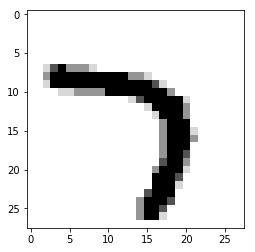

In [13]:
i=60
classify(i,True)

***References:***
* https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d
* https://machinelearningmastery.com/save-load-keras-deep-learning-models/